In [1]:
#Imports
from siphon.catalog import TDSCatalog
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
import metpy.calc as mpcalc
import xesmf as xe

In [2]:
#List the Datasets that are available to us
catalog = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/catalog.xml')
catalog.catalog_refs

['Forecast Model Data', 'Forecast Products and Analyses', 'Observation Data', 'Radar Data', 'Satellite Data', 'Unidata case studies']

In [10]:
#We want the Forecast Model Data, so we will choose that link
model1_catalog = catalog.catalog_refs['Forecast Model Data'].follow()

#Create 2 ipython dropdown widgets
dropdown = widgets.Dropdown(
    #Fill with the Models to Choose From
    options=["NAM CONUS 12km from NOAAPORT","GFS Quarter Degree Forecast", "GFS Half Degree Forecast"],
    value="GFS Quarter Degree Forecast",
    description='Model:',
    disabled=False,
)

dropdown2 = widgets.Dropdown(
    #Leave empty for now
    options = '',
    description='Run:',
    disabled=False,
)

#Function to fill the second dropdown menu with available model times
def dropdown2_eventhandler(country):
    try:
        dropdown2.options = model1_catalog.catalog_refs[str(dropdown.value)].follow().catalog_refs
    except:
        print("Choose different file!")
    return

#Needed for the interactivity of the first dropdown for consistency
def print_pass(city):
    return

#Interactively link the widgets to functions to change the data when a new model is selected
j = widgets.interactive(print_pass,city=dropdown2)
i = widgets.interactive(dropdown2_eventhandler, country=dropdown)

#Display the widgets
display(i)
display(j)

interactive(children=(Dropdown(description='Model:', index=1, options=('NAM CONUS 12km from NOAAPORT', 'GFS Qu…

interactive(children=(Dropdown(description='Run:', options=['GFS_Global_0p25deg_20210116_0000.grib2', 'GFS_Glo…

In [27]:
#Grab the catalog of data from the model we chose
m1_catalog = model1_catalog.catalog_refs[str(dropdown.value)].follow()

#Grab the Dataset for the model run time we selected
m1 = m1_catalog.catalog_refs[str(dropdown2.value)].follow()

#Open the Dataset in xarray and parse it with cf conventions
#This will allow us to add in any missing coordinates with metpy
ds1 = xr.open_dataset(str(m1.datasets[0].access_urls['OPENDAP'])).metpy.parse_cf()

In [28]:
#Now we try and find the times, these two models have either time1 or time2 depending on the variable
try:
    times = ds1.time2[ds1.time2<np.datetime64('now')]
except:
    times = ds1.time1[ds1.time1<np.datetime64('now')]

#Get a list of variables for the models
variables_temp = list(ds1.data_vars)
variables = []

#For now, this only concerns 2-meter temperatures, so only have those as options
[variables.append(x) for x in variables_temp if "Temperature_height" in x]

#Create two ipython dropdown widgets for the model forecast times we can choose from and the variables
time_dropdown = widgets.Dropdown(
    options= list(times[:].values),
    description='Time:',
    disabled=False,
)
variable_dropdown = widgets.Dropdown(
    options= variables,
    description='Variable:',
    disabled=False,
)

#Display the widgets
display(time_dropdown)
display(variable_dropdown)

Dropdown(description='Time:', options=(numpy.datetime64('2021-01-08T18:00:00.000000000'), numpy.datetime64('20…

Dropdown(description='Variable:', options=('Temperature_height_above_ground',), value='Temperature_height_abov…

In [29]:
#Grab the observation data from the THREDDS catalog
obs_catalog = catalog.catalog_refs['Forecast Products and Analyses'].follow()
obs = obs_catalog.catalog_refs["Real Time Mesoscale Analysis 2.5 km"].follow()

#Filter the observations to get the time closest to the model forecast that was chosen
obs = obs.catalog_refs.filter_time_nearest(datetime.utcfromtimestamp(time_dropdown.value.astype('O')/1e9)).follow()

#Open the dataset in xarray with cf standards 
obs_data = xr.open_dataset(
    str(obs.datasets[0].access_urls['OPENDAP'])
).metpy.parse_cf()

#This does not have lat/lon coords, so add them in
obs_data = obs_data.metpy.assign_latitude_longitude()

#Pull out the 2-meter temperature data
temp = obs_data["Temperature_Analysis_height_above_ground"]

#Now check if our model forecast dataset contains lat/lon coords, if not, add them in
if "lat" in list(ds1[variable_dropdown.value].coords):
    ds_out = xr.Dataset({'lat': ds1.lat,
                     'lon': ds1.lon,
                    }
                   )
else:
    ds1 = ds1.metpy.assign_latitude_longitude()
    ds1 = ds1.rename({"longitude": "lon","latitude": "lat"})
    ds_out = xr.Dataset({'lat': ds1.lat,
                     'lon': ds1.lon,
                    }
                   )
    
#The observations are on a different size grid compared to the model forecasts!
#We will used XESMF-python package to regrid the observations to the model grid

#To regrid, we need to create a Regridder function using the grid from the model
#Regridder(our data, grid dimensions to regrid to, type of regridding algorithm)
#We have a try statement as the GFS and NAM grids are setup differently
try:
    regridder = xe.Regridder(temp, ds_out.sel(lat=slice(55,20),lon=slice(230,300)), 'bilinear')
except:
    regridder = xe.Regridder(temp, ds_out, 'bilinear')  
    
#Once the function is created, we can regrid our data
dr_out = regridder(temp[0,0])


/home/mariofire/anaconda3/envs/meteorology/lib/python3.6/site-packages/xarray/core/dataarray.py:738: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/mariofire/anaconda3/envs/meteorology/lib/python3.6/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/home/mariofire/anaconda3/envs/meteorology/lib/python3.6/site-packages/xesmf/frontend.py:451: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


/home/mariofire/anaconda3/envs/meteorology/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


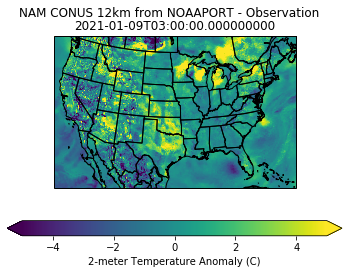

In [30]:
#Now we need to compare the two datasets, so we will subtract them from each other
#Since they can have different time coordinates, we need to check for each one separately
if "time" in list(ds1[variable_dropdown.value].coords):
    im_data = ds1[variable_dropdown.value].sel(time=time_dropdown.value)[0] - dr_out
elif "time1" in list(ds1[variable_dropdown.value].coords):
    im_data = ds1[variable_dropdown.value].sel(time1=time_dropdown.value)[0] - dr_out
elif "time2" in list(ds1[variable_dropdown.value].coords):     
    im_data = ds1[variable_dropdown.value].sel(time2=time_dropdown.value)[0] - dr_out
else:
    print("Unable to Find Time Coordinate!")

#Once we have the anomaly dataset, we can plot it
#Since the two grids are different, we will have two plotting functions separated by the try statement
try: #For GFS
    ax = plt.axes(projection=ccrs.LambertConformal())    
    im_data.sel(lat=slice(50,23), lon=slice(238,290)).plot.pcolormesh(transform=ccrs.PlateCarree(),vmin = -5, vmax = 5, extend = 'both', cbar_kwargs={
        "orientation": "horizontal",
        "label": "2-meter Temperature Anomaly (C)",
        
    })  # passed to plt.colorbar)
    ax.add_feature(cfeature.STATES.with_scale('10m'))
    plt.title(str(time_dropdown.value))
    plt.suptitle(str(dropdown.value) + " - Observation")
    
except:#For NAM
    ax = plt.axes(projection = ccrs.LambertConformal())
    ax.set_extent([-120,-72,24,50],ccrs.PlateCarree())
    im_data.plot.pcolormesh("lon","lat",transform=ccrs.PlateCarree(),vmin = -5, vmax = 5, extend = 'both', cbar_kwargs={
        "orientation": "horizontal",
        "label": "2-meter Temperature Anomaly (C)",
        
    })  # passed to plt.colorbar)
    ax.add_feature(cfeature.STATES.with_scale('10m'))
    plt.title(str(time_dropdown.value))
    plt.suptitle(str(dropdown.value) + " - Observation")
    
